## Fonctions

In [4]:
import pandas as pd # pour afficher les matrices sous forme de tableau
import numpy as np 
import numpy.linalg as la
import numpy.polynomial.polynomial as nppol
import scipy as sp
import scipy.linalg as sla
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importer Axes3D depuis la sous-bibliothèque mpl_toolkits.mplot3d
import scipy.optimize as sc
import scipy.integrate  as si # intégrale
import scipy.misc as derv
import random
from matplotlib.animation import FuncAnimation
from PIL import Image
import os

#FONCTION 
def initialisation (taille, MaxX1, MinX1, MaxX2, MinX2, empty):
    population = []
    if(empty):
        for _ in range(taille):
            x = np.zeros(2)
            obj = 0
            individu = Individu(x, obj)
            population.append(individu)
    else:
        for _ in range(taille):
            x = np.array([np.random.uniform(MinX1, MaxX1), np.random.uniform(MinX2, MaxX2)])
            obj = fonctionObj(x[0], x[1])             # Initialise fonction objective à 0
            individu = Individu(x, obj)
            population.append(individu)

    return population

def tournoi(Ntour, population):
    populationNew = [None] * len(population)
    for index, _ in enumerate(populationNew):
        max = Individu([0, 0], -np.inf)
        for i in np.random.choice(population, Ntour, replace=True):
            if max.obj < i.obj:
                max = i
        populationNew[index] = max  # Met à jour populationNew
    return populationNew

def Roue(Sp, population):
    tri = sorted(population, key=lambda individu: individu.obj, reverse=False)
    P = []
    for index, _ in enumerate(tri):
        P.append(1/len(population)*((Sp-2*(Sp-1)*(index)/(len(population)-1))))
    for index, _ in enumerate(tri):
        aleat = np.random.uniform(0,1)
        compter = 0
        for index2, individu in enumerate(tri):
            compter += P[index2]
            if(aleat <= compter):
                population[index] = individu
                break
    return population

def lineaireetendue(population, alpha, MaxX1, MinX1, MaxX2, MinX2, taille):
    newpopulation = initialisation(taille, MaxX1, MinX1, MaxX2, MinX2, 1)
    for index in range(len(newpopulation) // 2):
        #Selection des 2 parents et les supprimers
        P = np.random.choice(population, 2, replace=False)
        #Calcul des enfants 
        u = np.random.uniform(0, 1)
        gamma = u*(1+2*alpha) - alpha
        newpopulation[index*2].x = P[0].x*gamma +P[1].x*(1-gamma)
        newpopulation[index*2+1].x = P[0].x*(1-gamma)+P[1].x*gamma
        # Si hors limite => prendre un des 2 parents au hasard
        if(newpopulation[index*2].x[0] > MaxX1 or newpopulation[index*2].x[0] < MinX1 or newpopulation[index*2].x[1] > MaxX2 or newpopulation[index*2].x[1] < MinX2):
            if(np.random.uniform(0, 1)):
                newpopulation[index*2].x = P[0].x
            else:
                newpopulation[index*2].x = P[1].x
        
        if(newpopulation[index*2+1].x[0] > MaxX1 or newpopulation[index*2+1].x[0] < MinX1 or newpopulation[index*2+1].x[1] > MaxX2 or newpopulation[index*2+1].x[1] < MinX2):
            if(np.random.uniform(0, 1)):
                newpopulation[index*2+1].x = P[0].x
            else:
                newpopulation[index*2+1].x = P[1].x
    calculObj(newpopulation)
    return newpopulation

def calculObj(population):
    for index, _ in enumerate(population):
        population[index].obj = fonctionObj(population[index].x[0], population[index].x[1])

def moyenne(population):
    moyenne = 0
    for individu in population:
        moyenne += individu.obj
    return moyenne/len(population)

def mutation(population, g, MutMax, Gmax, Max, Min):
    nbMut = MutMax #np.random.randint(1, MutMax+1)
    for mut in range(nbMut):
        index = np.random.randint(0, len(population))
        #print("index",index)
        choixGene = np.random.randint(0, 2)
        deltaI = 2*np.random.randint(0, 2) - 1
        r = np.random.uniform(0, 1)
        if deltaI == 1:
            GammaI = r*(max(population, key=lambda individu: individu.x[choixGene]).x[choixGene]-population[index].x[choixGene])*(1-g/Gmax)
        else :
            GammaI = r*(population[index].x[choixGene]-min(population, key=lambda individu: individu.x[choixGene]).x[choixGene])*(1-g/Gmax)
        population[index].x[choixGene] = population[index].x[choixGene] + deltaI*GammaI
        #print("Valeur mutation", population[index].x[choixGene])
        population[index].x[choixGene] = np.maximum(population[index].x[choixGene], Min)
        population[index].x[choixGene] = np.minimum(population[index].x[choixGene], Max)
        population[index].Obj = fonctionObj(population[index].x[0], population[index].x[1])
    return population

#Affichage
def afficher_population(population):
    data = {
        'x1': [individu.x[0] for individu in population],
        'x2': [individu.x[1] for individu in population],
        'obj': [individu.obj for individu in population]
    }
    df = pd.DataFrame(data)
    pd.set_option('display.max_rows', None)
    print(df)

def afficher_graph(population, backup, g):
    print("f =", backup[g], "x1 = ",population[0].x[0],"x2 = ", population[0].x[1],"g =", g)
    plt.plot(range(g+1), backup)
    plt.xlabel("g")
    plt.ylabel("Backup")
    plt.title("Évolution de Backup en fonction de g")
    plt.show() 

# Fonction pour mettre à jour le graphique à chaque itération
def update(frame, population):
    if frame == 0:
        return

    # Mettez à jour la population avec vos étapes (Sélection, Croisement, Mutation)
    g = frame
    # Mettez à jour la population avec vos étapes de sélection, croisement et mutation ici

    # Créez un nouveau graphique à chaque itération
    plt.figure(figsize=(8, 6))
    x1_values = [individu.x[0] for individu in population]
    x2_values = [individu.x[1] for individu in population]

     # Définissez les limites d'axe pour x1 et x2
    x1_limit = (-10, 10)  # À adapter en fonction de vos limites
    x2_limit = (-10, 10)  # À adapter en fonction de vos limites
    plt.scatter(x1_values, x2_values)
    plt.xlim(x1_limit)
    plt.ylim(x2_limit)
    plt.title(f'Iteration {frame}')
    plt.xlabel('x1')    
    plt.ylabel('x2')

    # Enregistrez le graphique dans un fichier image
    plt.savefig(f'iteration_{frame}.png')

    # Fermez le graphique pour libérer la mémoire
    plt.close()







#Individu
class Individu:
    def __init__(self, x, obj):
        self.x = x
        self.obj = obj
###########################################################################################

## Main

précision =  3.2582192366348295e-07
f = -0.9999958416305158 x1 =  3.1415335661149513 x2 =  3.140514173155264 g = 47


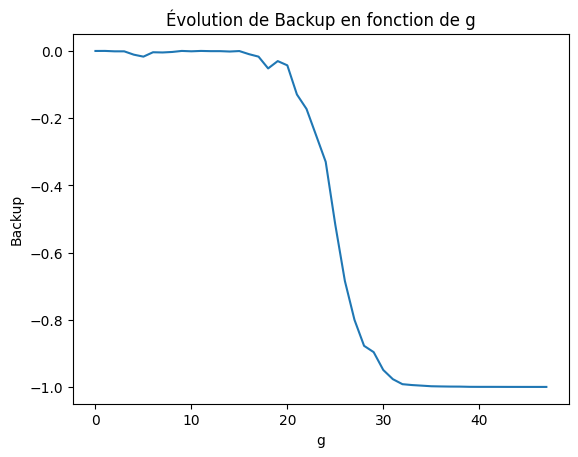

"\n# Enregistrez les images en tant que GIF\nimages = []\nfor frame in range(g):\n    img = Image.open(f'iteration_{frame+1}.png')\n    images.append(img)\n\nimages[0].save('population_evolution.gif', save_all=True, append_images=images[1:], duration=200, loop=0)\n"

In [5]:

#Variable
taille = 100
Sp = 2
alpha = 0.9
MaxX1 = 10
MinX1 = -10
MaxX2 = 10
MinX2 = -10
g = 0
MutMax = 2
Gmax = 200
precision = 10**-6

#Fonction objective 
#def fonctionObj(x1, x2) :
    #return x1**2 + x2**2
#def fonctionObj(x1, x2) :
    #return 100*(x2-x1**2)**2 + (x1-1)**2
#def fonctionObj(x1, x2) :
    #return 2 + (x1**2 - np.cos(2 * np.pi * x1)) + (x2**2 - np.cos(2 * np.pi * x2))
def fonctionObj(x1, x2) :
    return -np.cos(x1) * np.cos(x2) * np.exp(-((x1 - np.pi)**2 + (x2 - np.pi)**2))

#Initialisation
population = initialisation(taille, MaxX1, MinX1, MaxX2, MinX2, 0)
#afficher_population(population)  # Affiche les valeurs x1, x2 et obj dans un DataFrame
#print(moyenne(population))

# Créez l'animation
# ani = FuncAnimation(plt.figure(), update, frames=range(g + 1), repeat=False)

#Paramètres boucle
backup = []
backup.append(moyenne(population))

firstTime = 0
while((np.abs(backup[g-1] - moyenne(population)) > precision and g < Gmax) or firstTime == 0) :
    g = g + 1
    firstTime = 1
    #Selection
    #population = tournoi(4, population)
    population = Roue(Sp, population)
    #afficher_population(population)
    #print(moyenne(population))

    #Croisement
    population = lineaireetendue(population, alpha, MaxX1, MinX1, MaxX2, MinX2, taille)
    #afficher_population(population)
    #print(moyenne(population))

    #Mutation
    mutation(population, g, MutMax, Gmax, MaxX1, MinX1)
    #afficher_population(population)

    #afficher_population(population, fctObj)  # Affiche les valeurs x1, x2 et obj dans un DataFrame
    backup.append(moyenne(population))
    #print(np.abs(backup[g-1]), moyenne(population))
    #update(g, population)

print("précision = ", (np.abs(backup[g-1] - moyenne(population))))
afficher_graph(population, backup, g)

"""
# Enregistrez les images en tant que GIF
images = []
for frame in range(g):
    img = Image.open(f'iteration_{frame+1}.png')
    images.append(img)

images[0].save('population_evolution.gif', save_all=True, append_images=images[1:], duration=200, loop=0)
"""

In [ ]:
# Supprimez les fichiers d'image temporaires
for frame in range(g):
    filename = f'iteration_{frame+50}.png'
    try:
        os.remove(filename)
    except OSError:
        pass